<a href="https://colab.research.google.com/github/nickimps/Permanent-Magnet-Synchronous-Motor-Temperature-Estimation/blob/main/Data_Curation_and_Conditioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Curation and Conditioning

Nicholas Imperius 0645031\
Jimmy Tsang 1098204

Data preprocessing, transformation, normalization, augmentation, etc.

# Initialization

**Mounting Google Drive, Importing Libraries, Load Data**

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import math
import sklearn
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Data Preprocessing

In [ ]:
# load measures_v2.csv dataset
measures_df = pd.read_csv('/content/drive/MyDrive/ESOF-3675/Project/measures_v2.csv')

## Synthetic Attribute Derivation

Generate additional features to obtain better results

In [ ]:
#Voltage Magnitude
U = []
I = []
S = []
P = []
IMM = []
SMM = []
IMC = []
SMC = []

for i, row in measures_df.iterrows():
  eqnU = math.sqrt((row['u_d']*row['u_d']) + (row['u_q']*row['u_q']))
  U.append(eqnU)

  eqnI = math.sqrt((row['i_d']*row['i_d']) + (row['i_q']*row['i_q']))
  I.append(eqnI)

  eqnS = eqnU * eqnI
  S.append(eqnS)

  eqnP = (row['u_d']*row['i_d']) + (row['u_q']*row['i_q'])
  P.append(eqnP)

  eqnIMM = eqnI * row['motor_speed']
  IMM.append(eqnIMM)

  eqnSMM = eqnS * row['motor_speed']
  SMM.append(eqnSMM)

  eqnIMC = eqnI * row['coolant']
  IMC.append(eqnIMC)

  eqnSMC = eqnS * row['coolant']
  SMC.append(eqnSMC)

Append the new features to measures_df

In [ ]:
synthetic_df = pd.DataFrame()
synthetic_df['U'] = U
synthetic_df['I'] = I
synthetic_df['S'] = S
synthetic_df['P'] = P
synthetic_df['IMM'] = IMM
synthetic_df['SMM'] = SMM
synthetic_df['IMC'] = IMC
synthetic_df['SMC'] = SMC

In [ ]:
synthetic_df.head()

,U,I,S,P,IMM,SMM,IMC,SMC
0,0.570659,0.004431,0.002529,-0.001695,1.269819e-05,7.246341e-06,0.083331,0.047554
1,0.446789,0.000992,0.000443,0.000071,2.547010e-07,1.137975e-07,0.018666,0.008340
2,0.577165,0.001346,0.000777,-0.000651,3.170383e-06,1.829834e-06,0.025348,0.014630
3,0.454893,0.002046,0.000931,-0.000677,1.248905e-05,5.681180e-06,0.038534,0.017529
4,0.576530,0.074292,0.042832,0.003852,2.327433e-04,1.341835e-04,1.400924,0.807675


In [ ]:
measures_df = measures_df.join(synthetic_df)

## Remove Outliers

Verify measures dataframe

In [ ]:
measures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 21 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
 13  U               1330816 non-null  float64
 14  I               1330816 non-null  float64
 15  S               1330816 non-null  float64
 16  P               1330816 non-null  fl

Show stats of each column

In [ ]:
measures_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
u_q,1330816.0,5.427900e+01,4.417323e+01,-2.529093e+01,12.069925,4.893818e+01,9.003439e+01,1.330370e+02
coolant,1330816.0,3.622999e+01,2.178615e+01,1.062375e+01,18.698135,2.690014e+01,4.985749e+01,1.015985e+02
stator_winding,1330816.0,6.634275e+01,2.867206e+01,1.858582e+01,42.787957,6.511013e+01,8.814114e+01,1.413629e+02
u_d,1330816.0,-2.513381e+01,6.309197e+01,-1.315304e+02,-78.690904,-7.429755e+00,1.470271e+00,1.314698e+02
stator_tooth,1330816.0,5.687858e+01,2.295223e+01,1.813398e+01,38.416012,5.603635e+01,7.558668e+01,1.119464e+02
motor_speed,1330816.0,2.202081e+03,1.859663e+03,-2.755491e+02,317.110665,1.999977e+03,3.760639e+03,6.000015e+03
i_d,1330816.0,-6.871681e+01,6.493323e+01,-2.780036e+02,-115.406060,-5.109376e+01,-2.979688e+00,5.189670e-02
i_q,1330816.0,3.741278e+01,9.218188e+01,-2.934268e+02,1.095863,1.577401e+01,1.006121e+02,3.017079e+02
pm,1330816.0,5.850678e+01,1.900150e+01,2.085696e+01,43.151582,6.026629e+01,7.200837e+01,1.136066e+02
stator_yoke,1330816.0,4.818796e+01,1.999100e+01,1.807669e+01,31.990333,4.562551e+01,6.146083e+01,1.011480e+02


Verify if there are any `NaN` values in the data set

In [ ]:
measures_df.isna().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
U                 0
I                 0
S                 0
P                 0
IMM               0
SMM               0
IMC               0
SMC               0
dtype: int64

Visualize outliers with boxplot of each column

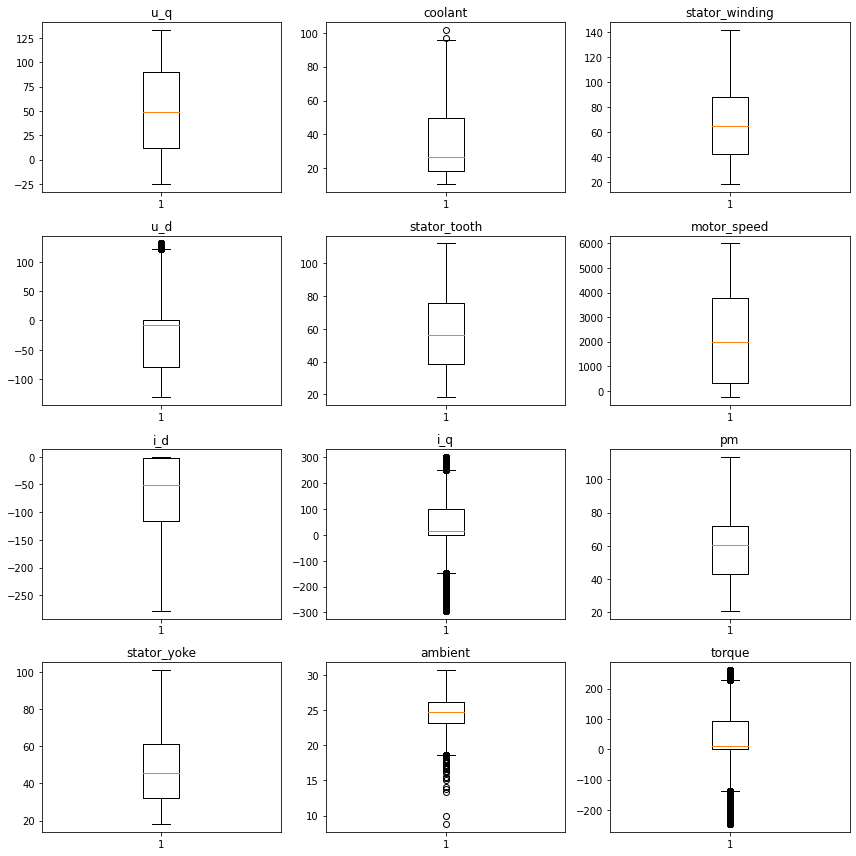

In [ ]:
columns = measures_df.columns

fig, ([u_q, coolant, stator_winding], [u_d, stator_tooth, motor_speed], [i_d, i_q, pm], [stator_yoke, ambient, torque]) = plt.subplots(4, 3, figsize=(12,12))

u_q.boxplot(measures_df['u_q'])
u_q.set_axisbelow(True)
u_q.set_title('u_q')

coolant.boxplot(measures_df['coolant'])
coolant.set_axisbelow(True)
coolant.set_title('coolant')

stator_winding.boxplot(measures_df['stator_winding'])
stator_winding.set_axisbelow(True)
stator_winding.set_title('stator_winding')

u_d.boxplot(measures_df['u_d'])
u_d.set_axisbelow(True)
u_d.set_title('u_d')

stator_tooth.boxplot(measures_df['stator_tooth'])
stator_tooth.set_axisbelow(True)
stator_tooth.set_title('stator_tooth')

motor_speed.boxplot(measures_df['motor_speed'])
motor_speed.set_axisbelow(True)
motor_speed.set_title('motor_speed')

i_d.boxplot(measures_df['i_d'])
i_d.set_axisbelow(True)
i_d.set_title('i_d')

i_q.boxplot(measures_df['i_q'])
i_q.set_axisbelow(True)
i_q.set_title('i_q')

pm.boxplot(measures_df['pm'])
pm.set_axisbelow(True)
pm.set_title('pm')

stator_yoke.boxplot(measures_df['stator_yoke'])
stator_yoke.set_axisbelow(True)
stator_yoke.set_title('stator_yoke')

ambient.boxplot(measures_df['ambient'])
ambient.set_axisbelow(True)
ambient.set_title('ambient')

torque.boxplot(measures_df['torque'])
torque.set_axisbelow(True)
torque.set_title('torque')

fig.tight_layout()

plt.show()

Convert the outliers to `NaN` values\
We consider anything outside of 2 standard deviations of the mean is considered to be an outlier\
Note: `new_measures_df` is the dataframe that contains the information without outliers while `measures_df` still contains outliers, this is useful for testing the performance between the type of data later on. 

In [ ]:
v = measures_df.values
mask = np.abs((v - v.mean(0)) / v.std(0)) > 2 
new_measures_df = pd.DataFrame(np.where(mask, np.nan, v), measures_df.index, measures_df.columns)

new_measures_df.isna().sum()

u_q                   0
coolant           94076
stator_winding    22869
u_d               61779
stator_tooth      19576
motor_speed       21418
i_d               60156
i_q               84776
pm                14760
stator_yoke       45282
ambient           68412
torque            85276
profile_id            0
U                     0
I                 26507
S                 46638
P                 68306
IMM               62753
SMM               64402
IMC               73949
SMC               72004
dtype: int64

Create `clean_measures_df` without any outliers at all

In [ ]:
clean_measures_df = new_measures_df.dropna()

In [ ]:
clean_measures_df.shape

(927029, 21)

Change the `NaN` to that column's median

In [ ]:
for col in new_measures_df.columns:
  new_measures_df[col].fillna(new_measures_df[col].median(), inplace=True)

new_measures_df.isna().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
U                 0
I                 0
S                 0
P                 0
IMM               0
SMM               0
IMC               0
SMC               0
dtype: int64

In [ ]:
new_measures_df.shape

(1330816, 21)

Reprint the boxplot for `new_measures_df`

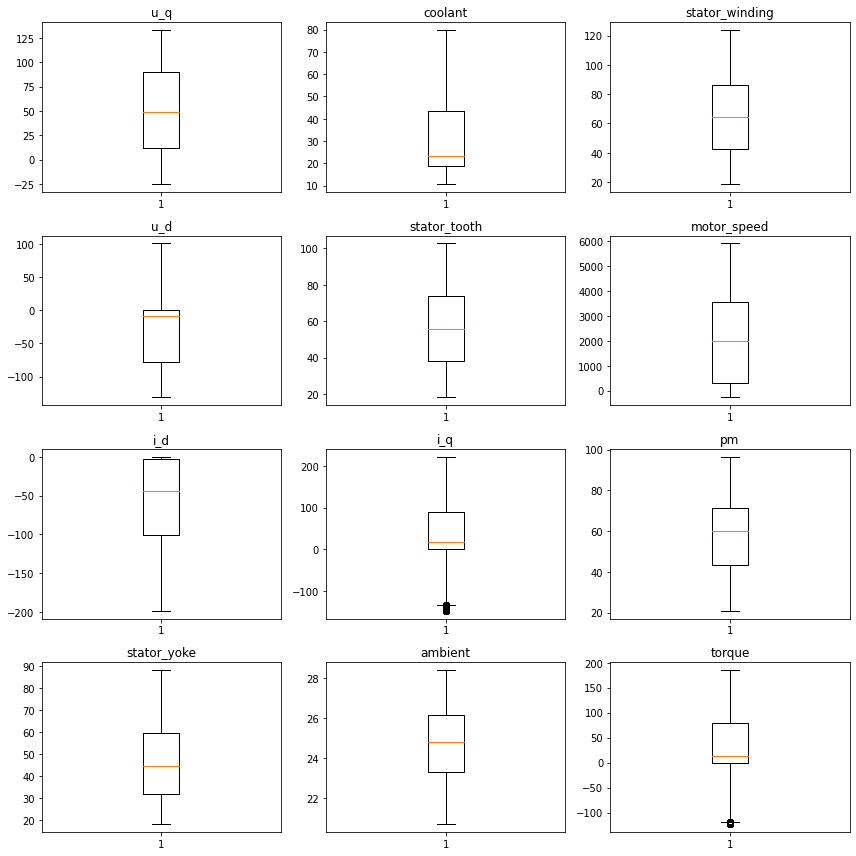

In [ ]:
columns = new_measures_df.columns

fig, ([u_q, coolant, stator_winding], [u_d, stator_tooth, motor_speed], [i_d, i_q, pm], [stator_yoke, ambient, torque]) = plt.subplots(4, 3, figsize=(12,12))

u_q.boxplot(new_measures_df['u_q'])
u_q.set_axisbelow(True)
u_q.set_title('u_q')

coolant.boxplot(new_measures_df['coolant'])
coolant.set_axisbelow(True)
coolant.set_title('coolant')

stator_winding.boxplot(new_measures_df['stator_winding'])
stator_winding.set_axisbelow(True)
stator_winding.set_title('stator_winding')

u_d.boxplot(new_measures_df['u_d'])
u_d.set_axisbelow(True)
u_d.set_title('u_d')

stator_tooth.boxplot(new_measures_df['stator_tooth'])
stator_tooth.set_axisbelow(True)
stator_tooth.set_title('stator_tooth')

motor_speed.boxplot(new_measures_df['motor_speed'])
motor_speed.set_axisbelow(True)
motor_speed.set_title('motor_speed')

i_d.boxplot(new_measures_df['i_d'])
i_d.set_axisbelow(True)
i_d.set_title('i_d')

i_q.boxplot(new_measures_df['i_q'])
i_q.set_axisbelow(True)
i_q.set_title('i_q')

pm.boxplot(new_measures_df['pm'])
pm.set_axisbelow(True)
pm.set_title('pm')

stator_yoke.boxplot(new_measures_df['stator_yoke'])
stator_yoke.set_axisbelow(True)
stator_yoke.set_title('stator_yoke')

ambient.boxplot(new_measures_df['ambient'])
ambient.set_axisbelow(True)
ambient.set_title('ambient')

torque.boxplot(new_measures_df['torque'])
torque.set_axisbelow(True)
torque.set_title('torque')

fig.tight_layout()

plt.show()

## Apply EWMA

In [ ]:
measures_df = measures_df.ewm(com=0.5).mean()
new_measures_df = new_measures_df.ewm(com=0.5).mean()
clean_measures_df = clean_measures_df.ewm(com=0.5).mean()

## Splitting and Normalization

Split the `new_measures_df` and `measures_df` into proper training and testing splits as well as normalize both dataframes

In [ ]:
#Extracting Input and Output variables
x = measures_df[['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient', 'torque']]
x_synth = measures_df[['U', 'I', 'S', 'P', 'IMM', 'SMM', 'IMC', 'SMC']]
y = measures_df[['stator_winding', 'stator_tooth', 'stator_yoke', 'pm']]

In [ ]:
new_x = new_measures_df[['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient', 'torque']]
new_x_synth = new_measures_df[['U', 'I', 'S', 'P', 'IMM', 'SMM', 'IMC', 'SMC']]
new_y = new_measures_df[['stator_winding', 'stator_tooth', 'stator_yoke', 'pm']]

In [ ]:
clean_x = clean_measures_df[['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient', 'torque']]
clean_x_synth = clean_measures_df[['U', 'I', 'S', 'P', 'IMM', 'SMM', 'IMC', 'SMC']]
clean_y = clean_measures_df[['stator_winding', 'stator_tooth', 'stator_yoke', 'pm']]

**Splitting Data for Training/Testing Split**\
As explained in our document, we have found that a 7:3 split between training and testing is the most optimal

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size = 0.3, random_state = 0)
clean_x_train, clean_x_test, clean_y_train, clean_y_test = train_test_split(clean_x, clean_y, test_size = 0.3, random_state = 0) 

In [ ]:
x_train_synth, x_test_synth, y_train_synth, y_test_synth = train_test_split(x_synth, y, test_size = 0.3, random_state = 0)
new_x_train_synth, new_x_test_synth, new_y_train_synth, new_y_test_synth = train_test_split(new_x_synth, new_y, test_size = 0.3, random_state = 0)
clean_x_train_synth, clean_x_test_synth, clean_y_train_synth, clean_y_test_synth = train_test_split(clean_x_synth, clean_y, test_size = 0.3, random_state = 0) 

**Normalization of our data, explaination in full provided in the report**\
The general gist is that because our x values vary in size because of the diff. attrib. we should norm. to [0, 1]

In [ ]:
x_train = preprocessing.minmax_scale(x_train)
x_test = preprocessing.minmax_scale(x_test)

x_train_synth = preprocessing.minmax_scale(x_train_synth)
x_test_synth = preprocessing.minmax_scale(x_test_synth)

print(x_train, x_test)

[[0.23587286 0.06032058 0.50351134 ... 0.49482501 0.59790207 0.485847  ]
 [0.93556544 0.21754468 0.52702117 ... 0.47948164 0.76956007 0.47150436]
 [0.55915667 0.05683165 0.25640243 ... 0.71584378 0.42020432 0.68845557]
 ...
 [0.36075977 0.48100417 0.71379344 ... 0.20007977 0.85515246 0.2143489 ]
 [0.75806498 0.06122979 0.49536839 ... 0.49482315 0.63563106 0.48471549]
 [0.15257426 0.0540352  0.50565538 ... 0.49482458 0.73923655 0.49652258]] [[0.42572811 0.08335618 0.03021368 ... 0.62336676 0.51341506 0.63302593]
 [0.15697329 0.586284   0.49692323 ... 0.49469452 0.70149613 0.48542277]
 [0.14991956 0.25945352 0.49903084 ... 0.49469504 0.63906973 0.48542278]
 ...
 [0.35699923 0.08799152 0.34486675 ... 0.78365017 0.71835738 0.76004432]
 [0.87467155 0.0757703  0.24434162 ... 0.60109366 0.65258955 0.5849534 ]
 [0.6719353  0.46279798 0.11452421 ... 0.5888367  0.72887655 0.59051378]]


In [ ]:
new_x_train = preprocessing.minmax_scale(new_x_train)
new_x_test = preprocessing.minmax_scale(new_x_test)

new_x_train_synth = preprocessing.minmax_scale(new_x_train_synth)
new_x_test_synth = preprocessing.minmax_scale(new_x_test_synth)

print(new_x_train, new_x_test)

[[0.23587286 0.07728366 0.56963556 ... 0.40130974 0.31901104 0.3992587 ]
 [0.93556544 0.27872162 0.59623284 ... 0.37653813 0.73554253 0.37564182]
 [0.55915667 0.07281359 0.29007478 ... 0.75814087 0.53265719 0.73287812]
 ...
 [0.36075977 0.61627003 0.8075332  ... 0.44378257 0.94323417 0.44139756]
 [0.75806498 0.07844856 0.56042322 ... 0.40130674 0.41056116 0.39739553]
 [0.15257426 0.06923074 0.57206116 ... 0.40130904 0.66196192 0.41683733]] [[0.42572811 0.1005142  0.03417115 ... 0.60897681 0.5327724  0.64196776]
 [0.15697329 0.70696461 0.56201161 ... 0.40126761 0.48693415 0.39897875]
 [0.14991956 0.3128594  0.56439528 ... 0.40126846 0.31797055 0.39897876]
 ...
 [0.35699923 0.10610368 0.39003835 ... 0.86771435 0.53257089 0.85106946]
 [0.87467155 0.09136685 0.27634616 ... 0.57302246 0.35456335 0.56282922]
 [0.6719353  0.55806025 0.12952491 ... 0.55323666 0.56104213 0.57198291]]


In [ ]:
clean_x_train = preprocessing.minmax_scale(clean_x_train)
clean_x_test = preprocessing.minmax_scale(clean_x_test)

clean_x_train_synth = preprocessing.minmax_scale(clean_x_train_synth)
clean_x_test_synth = preprocessing.minmax_scale(clean_x_test_synth)

print(clean_x_train, clean_x_test)

[[0.73406333 0.07729151 0.55826677 ... 0.40179955 0.38761287 0.38600153]
 [0.81600899 0.24034964 0.23589444 ... 0.5630883  0.7356466  0.55504242]
 [0.34266086 0.08509054 0.37554187 ... 0.75891942 0.22262412 0.73374931]
 ...
 [0.19576546 0.07200245 0.46593561 ... 0.75891872 0.08301276 0.73440083]
 [0.99361126 0.07345533 0.55258846 ... 0.40247168 0.43289034 0.3850382 ]
 [0.08166245 0.07030489 0.52863291 ... 0.91041943 0.3187882  0.90842061]] [[0.90004627 0.82226848 0.3259455  ... 0.50537531 0.42594489 0.49181083]
 [0.37827349 0.15363505 0.30334583 ... 0.81796615 0.70609621 0.78793408]
 [0.29491222 0.06209246 0.56103089 ... 0.4013743  0.40920218 0.38576148]
 ...
 [0.12253651 0.06733998 0.51097717 ... 0.75841406 0.2165132  0.73621895]
 [0.4133118  0.77630753 0.77114567 ... 0.11360381 0.89586851 0.11716507]
 [0.11079616 0.06589735 0.56500991 ... 0.40137373 0.22053636 0.38538678]]


# Model Implementation

## Linear Regression Model

### Model with `measures_df` data

Create the Linear Regression model and fit the data to it

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

Test the accuracy of the model for the training and testing sets

In [ ]:
train_acc = (lin_reg.score(x_train, y_train)) * 100
test_acc = (lin_reg.score(x_test, y_test)) * 100

print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)

Train Accuracy:  73.41549254006539
Test Accuracy:  71.89433044599014


Predict the test values

In [ ]:
test_pred = lin_reg.predict(x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
lin_r2 = r2_score(y_test, test_pred)
lin_mae = mean_absolute_error(y_test, test_pred)
lin_mse = mean_squared_error(y_test, test_pred)

print("R2 Score: ", lin_r2)
print("MAE: ", lin_mae)
print("MSE: ", lin_mse)

R2 Score:  0.7189433044599014
MAE:  9.260226787466872
MSE:  148.22900904589642


Print the first 5 predictions

In [ ]:
predictions = pd.DataFrame(np.c_[y_test, test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,87.247586,65.909008,46.386985,67.055615
1,85.115196,76.316637,67.217627,72.509083,67.317224,63.999195,62.608703,61.629273
2,48.690977,45.343004,39.481600,43.029770,46.524364,42.976698,39.955174,50.317188
3,104.791174,90.296399,72.123615,74.901335,112.036208,91.875628,72.247561,96.754140
4,113.346712,84.136667,57.476615,89.908331,98.684962,73.486641,51.311993,77.019095


Display a visualization of all the predictions compared with the original temperature

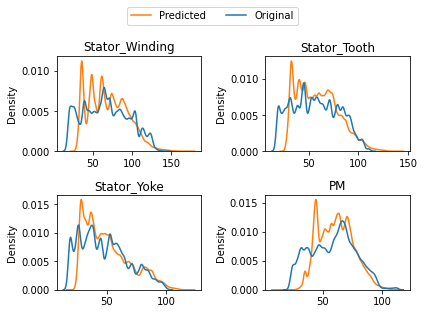

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `new_measures_df` data

Create the Linear Regression model and fit the data to it

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(new_x_train, new_y_train)

LinearRegression()

Test the accuracy of the model for the training and testing sets

In [ ]:
new_train_acc = (lin_reg.score(new_x_train, new_y_train)) * 100
new_test_acc = (lin_reg.score(new_x_test, new_y_test)) * 100

print("Train Accuracy: ", new_train_acc)
print("Test Accuracy: ", new_test_acc)

Train Accuracy:  51.50562779999365
Test Accuracy:  51.44814141857632


Predict the test values

In [ ]:
test_pred = lin_reg.predict(new_x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
new_lin_r2 = r2_score(new_y_test, test_pred)
new_lin_mae = mean_absolute_error(new_y_test, test_pred)
new_lin_mse = mean_squared_error(new_y_test, test_pred)

print("R2 Score: ", new_lin_r2)
print("MAE: ", new_lin_mae)
print("MSE: ", new_lin_mse)

R2 Score:  0.5144814141857632
MAE:  11.52830538013993
MSE:  234.91374542159747


Print the first 5 predictions

In [ ]:
predictions = pd.DataFrame(np.c_[new_y_test, test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,98.701245,75.433904,52.138341,72.863957
1,85.115196,76.316637,67.217627,72.509083,64.414297,61.508423,60.200920,58.820042
2,48.690977,45.343004,39.481600,43.029770,47.569568,43.915694,40.818786,46.622629
3,104.791174,90.296399,72.123615,74.901335,120.484669,97.463326,74.406193,91.515063
4,113.346712,84.136667,57.476615,89.908331,78.784194,65.009229,47.129642,69.286521


Display a visualization of all the predictions compared with the original temperature

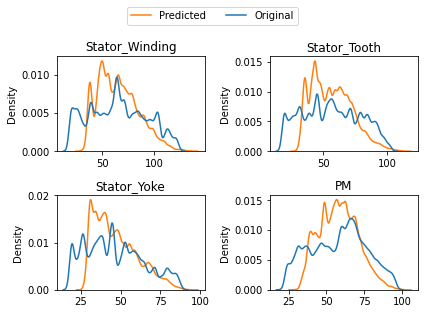

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `clean_measures_df` data

Create the Linear Regression model and fit the data to it

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(clean_x_train, clean_y_train)

LinearRegression()

Test the accuracy of the model for the training and testing sets

In [ ]:
clean_train_acc = (lin_reg.score(clean_x_train, clean_y_train)) * 100
clean_test_acc = (lin_reg.score(clean_x_test, clean_y_test)) * 100

print("Train Accuracy: ", clean_train_acc)
print("Test Accuracy: ", clean_test_acc)

Train Accuracy:  72.5622051836001
Test Accuracy:  72.46986352403287


Predict the test values

In [ ]:
clean_test_pred = lin_reg.predict(clean_x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
clean_lin_r2 = r2_score(clean_y_test, clean_test_pred)
clean_lin_mae = mean_absolute_error(clean_y_test, clean_test_pred)
clean_lin_mse = mean_squared_error(clean_y_test, clean_test_pred)

print("R2 Score: ", clean_lin_r2)
print("MAE: ", clean_lin_mae)
print("MSE: ", clean_lin_mse)

R2 Score:  0.7246986352403287
MAE:  7.268268965860494
MSE:  101.75809803406918


Print the first 5 predictions

In [ ]:
predictions = pd.DataFrame(np.c_[clean_y_test, clean_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,90.472439,79.636578,72.121382,62.382602,88.957875,81.453555,74.030016,68.977951
1,51.863004,44.360201,36.413628,57.271817,59.936307,49.548931,40.132394,55.910478
2,21.319025,19.852433,19.850618,29.767839,29.896978,28.042302,24.638028,42.476773
3,24.899328,23.305051,22.380061,28.442768,25.443412,23.934896,22.118060,36.569910
4,19.761168,19.161161,19.122271,27.059434,26.055625,24.380496,22.251103,38.143963


Display a visualization of all the predictions compared with the original temperature

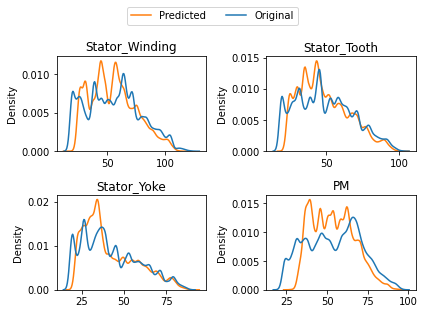

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `measures_df` synthetic data

Create the Linear Regression model and fit the data to it

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_synth, y_train_synth)

LinearRegression()

Test the accuracy of the model for the training and testing sets

In [ ]:
train_acc_synth = (lin_reg.score(x_train_synth, y_train_synth)) * 100
test_acc_synth = (lin_reg.score(x_test_synth, y_test_synth)) * 100

print("Train Accuracy: ", train_acc_synth)
print("Test Accuracy: ", test_acc_synth)

Train Accuracy:  47.60548370098464
Test Accuracy:  47.60915070812468


Predict the test values

In [ ]:
test_pred = lin_reg.predict(x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
lin_r2_synth = r2_score(y_test_synth, test_pred)
lin_mae_synth = mean_absolute_error(y_test_synth, test_pred)
lin_mse_synth = mean_squared_error(y_test_synth, test_pred)

print("R2 Score: ", lin_r2_synth)
print("MAE: ", lin_mae_synth)
print("MSE: ", lin_mse_synth)

R2 Score:  0.4760915070812468
MAE:  13.083099629273747
MSE:  270.2353282951295


Print the first 5 predictions

In [ ]:
predictions = pd.DataFrame(np.c_[y_test_synth, test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,91.431809,68.897641,47.050474,75.316335
1,85.115196,76.316637,67.217627,72.509083,46.227067,43.924892,41.985581,52.020728
2,48.690977,45.343004,39.481600,43.029770,45.823184,43.550552,41.626380,51.712084
3,104.791174,90.296399,72.123615,74.901335,107.878476,87.963457,70.309894,84.616173
4,113.346712,84.136667,57.476615,89.908331,91.492357,67.672463,45.632531,72.327576


Display a visualization of all the predictions compared with the original temperature

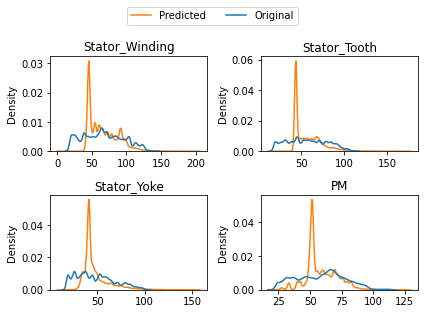

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `new_measures_df` synthetic data

Create the Linear Regression model and fit the data to it

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(new_x_train_synth, new_y_train_synth)

LinearRegression()

Test the accuracy of the model for the training and testing sets

In [ ]:
new_train_acc_synth = (lin_reg.score(new_x_train_synth, new_y_train_synth)) * 100
new_test_acc_synth = (lin_reg.score(new_x_test_synth, new_y_test_synth)) * 100

print("Train Accuracy: ", new_train_acc_synth)
print("Test Accuracy: ", new_test_acc_synth)

Train Accuracy:  31.841203631500115
Test Accuracy:  31.641502178980264


Predict the test values

In [ ]:
test_pred = lin_reg.predict(new_x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
new_lin_r2_synth = r2_score(new_y_test_synth, test_pred)
new_lin_mae_synth = mean_absolute_error(new_y_test_synth, test_pred)
new_lin_mse_synth = mean_squared_error(new_y_test_synth, test_pred)

print("R2 Score: ", new_lin_r2_synth)
print("MAE: ", new_lin_mae_synth)
print("MSE: ", new_lin_mse_synth)

R2 Score:  0.31641502178980263
MAE:  14.437817023433993
MSE:  315.3190513788657


Print the first 5 predictions

In [ ]:
predictions = pd.DataFrame(np.c_[new_y_test_synth, test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,82.654247,63.663289,46.780629,62.220324
1,85.115196,76.316637,67.217627,72.509083,44.747221,42.327278,40.324710,49.891988
2,48.690977,45.343004,39.481600,43.029770,44.561221,42.181669,40.163842,49.846172
3,104.791174,90.296399,72.123615,74.901335,103.738775,84.487353,66.454433,74.587182
4,113.346712,84.136667,57.476615,89.908331,91.376725,71.732694,52.677266,73.730338


Display a visualization of all the predictions compared with the original temperature

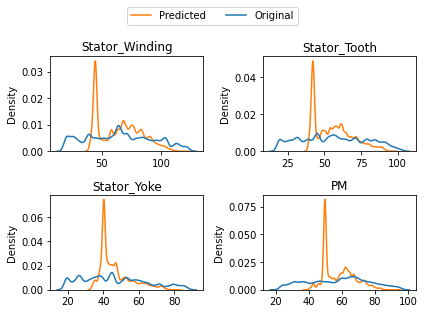

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `clean_measures_df` synthetic data

Create the Linear Regression model and fit the data to it

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(clean_x_train_synth, clean_y_train_synth)

LinearRegression()

Test the accuracy of the model for the training and testing sets

In [ ]:
clean_train_acc_synth = (lin_reg.score(clean_x_train_synth, clean_y_train_synth)) * 100
clean_test_acc_synth = (lin_reg.score(clean_x_test_synth, clean_y_test_synth)) * 100

print("Train Accuracy: ", clean_train_acc_synth)
print("Test Accuracy: ", clean_test_acc_synth)

Train Accuracy:  44.1482019919593
Test Accuracy:  44.227197646299345


Predict the test values

In [ ]:
clean_test_pred = lin_reg.predict(clean_x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
clean_lin_r2_synth = r2_score(clean_y_test_synth, clean_test_pred)
clean_lin_mae_synth = mean_absolute_error(clean_y_test_synth, clean_test_pred)
clean_lin_mse_synth = mean_squared_error(clean_y_test_synth, clean_test_pred)

print("R2 Score: ", clean_lin_r2_synth)
print("MAE: ", clean_lin_mae_synth)
print("MSE: ", clean_lin_mse_synth)

R2 Score:  0.44227197646299343
MAE:  11.119862173482966
MSE:  201.97930272698548


Print the first 5 predictions

In [ ]:
predictions = pd.DataFrame(np.c_[clean_y_test_synth, clean_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,90.472439,79.636578,72.121382,62.382602,73.954226,67.430734,60.532496,64.153358
1,51.863004,44.360201,36.413628,57.271817,55.141682,44.957594,36.224188,48.195023
2,21.319025,19.852433,19.850618,29.767839,41.552550,39.830718,37.072821,49.969295
3,24.899328,23.305051,22.380061,28.442768,42.439801,40.162901,38.061983,50.899294
4,19.761168,19.161161,19.122271,27.059434,42.426388,40.149474,38.050133,50.889276


Display a visualization of all the predictions compared with the original temperature

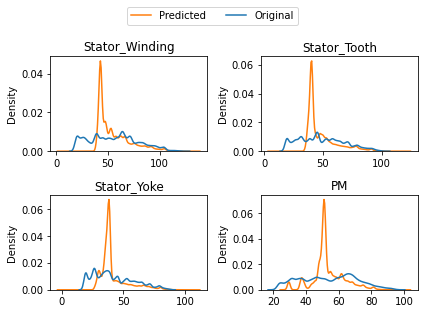

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

## Random Forest Decision Tree Regressor Model

### Model with `measures_df` data

Create the Random Forest Decision Tree Regressor and fit the data to it

In [ ]:
randForest = RandomForestRegressor(n_estimators = 10, random_state = 0)
randForest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
rf_train_acc = (randForest.score(x_train, y_train)) * 100
rf_test_acc = (randForest.score(x_test, y_test)) * 100

print("Train Accuracy: ", rf_train_acc)
print("Test Accuracy: ", rf_test_acc)

Train Accuracy:  99.82541518733534
Test Accuracy:  68.5545091375632


Predict the test values

In [ ]:
tree_pred = randForest.predict(x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
rf_r2 = r2_score(y_test, tree_pred)
rf_mae = mean_absolute_error(y_test, tree_pred)
rf_mse = mean_squared_error(y_test, tree_pred)

print("R2 Score: ", rf_r2)
print("MAE: ", rf_mae)
print("MSE: ", rf_mse)

R2 Score:  0.685545091375632
MAE:  8.694550462528436
MSE:  173.49264143229908


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[y_test, tree_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,64.703728,46.104756,32.827535,39.590052
1,85.115196,76.316637,67.217627,72.509083,79.662296,75.509295,72.688501,74.932159
2,48.690977,45.343004,39.481600,43.029770,71.502340,62.985072,53.452730,67.472246
3,104.791174,90.296399,72.123615,74.901335,88.230417,75.177195,62.534437,75.128384
4,113.346712,84.136667,57.476615,89.908331,113.291255,84.179558,57.509530,90.082849


Display a visualization of all the predictions compared with the original temperature

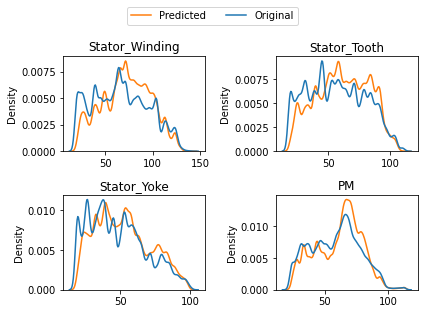

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `new_measures_df` data

Create the Random Forest Decision Tree Regressor and fit the data to it

In [ ]:
randForest = RandomForestRegressor(n_estimators = 10, random_state = 0)
randForest.fit(new_x_train, new_y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
new_rf_train_acc_synth = (randForest.score(new_x_train, new_y_train)) * 100
new_rf_test_acc_synth = (randForest.score(new_x_test, new_y_test)) * 100

print("Train Accuracy: ", new_rf_train_acc_synth)
print("Test Accuracy: ", new_rf_test_acc_synth)

Train Accuracy:  99.69926896652711
Test Accuracy:  60.11520582395018


Predict the test values

In [ ]:
tree_pred = randForest.predict(new_x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
new_rf_r2 = r2_score(new_y_test, tree_pred)
new_rf_mae = mean_absolute_error(new_y_test, tree_pred)
new_rf_mse = mean_squared_error(new_y_test, tree_pred)

print("R2 Score: ", new_rf_r2)
print("MAE: ", new_rf_mae)
print("MSE: ", new_rf_mse)

R2 Score:  0.6011520582395018
MAE:  8.80564139676959
MSE:  193.20566298046876


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[new_y_test, tree_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,74.222453,54.304587,37.542624,51.579992
1,85.115196,76.316637,67.217627,72.509083,82.389059,74.402065,66.556312,71.712672
2,48.690977,45.343004,39.481600,43.029770,56.237949,50.553485,43.414167,45.035689
3,104.791174,90.296399,72.123615,74.901335,99.198410,82.659384,66.342809,77.552258
4,113.346712,84.136667,57.476615,89.908331,113.203017,83.959384,57.475718,89.307683


Display a visualization of all the predictions compared with the original temperature

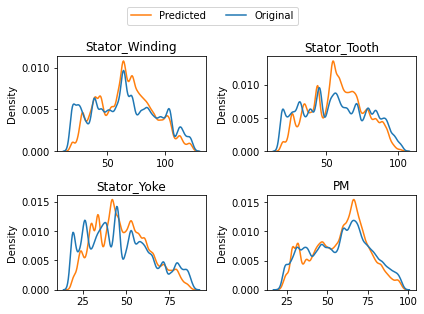

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `clean_measures_df` data

Create the Random Forest Decision Tree Regressor and fit the data to it

In [ ]:
randForest = RandomForestRegressor(n_estimators = 10, random_state = 0)
randForest.fit(clean_x_train, clean_y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
clean_rf_train_acc = (randForest.score(clean_x_train, clean_y_train)) * 100
clean_rf_test_acc = (randForest.score(clean_x_test, clean_y_test)) * 100

print("Train Accuracy: ", clean_rf_train_acc)
print("Test Accuracy: ", clean_rf_test_acc)

Train Accuracy:  99.76776991172034
Test Accuracy:  87.57919550113922


Predict the test values

In [ ]:
tree_pred = randForest.predict(clean_x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
clean_rf_r2 = r2_score(clean_y_test, tree_pred)
clean_rf_mae = mean_absolute_error(clean_y_test, tree_pred)
clean_rf_mse = mean_squared_error(clean_y_test, tree_pred)

print("R2 Score: ", clean_rf_r2)
print("MAE: ", clean_rf_mae)
print("MSE: ", clean_rf_mse)

R2 Score:  0.8757919550113922
MAE:  3.911817849176956
MSE:  47.07803664398267


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[clean_y_test, tree_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,90.472439,79.636578,72.121382,62.382602,81.283795,71.988754,68.878050,52.605488
1,51.863004,44.360201,36.413628,57.271817,51.851853,44.320395,36.366896,57.321398
2,21.319025,19.852433,19.850618,29.767839,29.495168,27.520829,24.931075,39.470423
3,24.899328,23.305051,22.380061,28.442768,22.434514,21.152867,20.654183,25.770372
4,19.761168,19.161161,19.122271,27.059434,22.434514,21.152867,20.654183,25.770372


Display a visualization of all the predictions compared with the original temperature

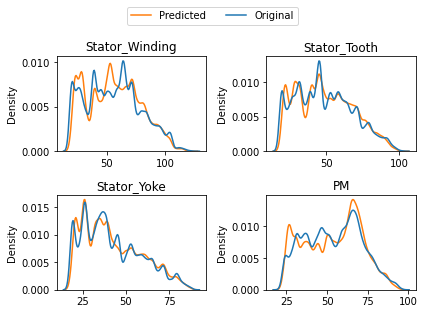

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `measures_df` synthetic data

Create the Random Forest Decision Tree Regressor and fit the data to it

In [ ]:
randForest = RandomForestRegressor(n_estimators = 10, random_state = 0)
randForest.fit(x_train_synth, y_train_synth)

RandomForestRegressor(n_estimators=10, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
rf_train_acc_synth = (randForest.score(x_train_synth, y_train_synth)) * 100
rf_test_acc_synth = (randForest.score(x_test_synth, y_test_synth)) * 100

print("Train Accuracy: ", rf_train_acc_synth)
print("Test Accuracy: ", rf_test_acc_synth)

Train Accuracy:  99.006497637282
Test Accuracy:  84.34077148985037


Predict the test values

In [ ]:
tree_pred = randForest.predict(x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
rf_r2_synth = r2_score(y_test_synth, tree_pred)
rf_mae_synth = mean_absolute_error(y_test_synth, tree_pred)
rf_mse_synth = mean_squared_error(y_test_synth, tree_pred)

print("R2 Score: ", rf_r2_synth)
print("MAE: ", rf_mae_synth)
print("MSE: ", rf_mse_synth)

R2 Score:  0.8434077148985037
MAE:  5.883872117446204
MSE:  84.54861948639393


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[y_test_synth, tree_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,64.941901,46.272215,32.174698,39.534431
1,85.115196,76.316637,67.217627,72.509083,51.869612,50.437122,51.095881,60.532298
2,48.690977,45.343004,39.481600,43.029770,54.021569,49.188429,43.210433,50.705309
3,104.791174,90.296399,72.123615,74.901335,91.911318,77.512359,62.914202,76.660999
4,113.346712,84.136667,57.476615,89.908331,113.038466,84.192464,57.500449,90.047128


Display a visualization of all the predictions compared with the original temperature

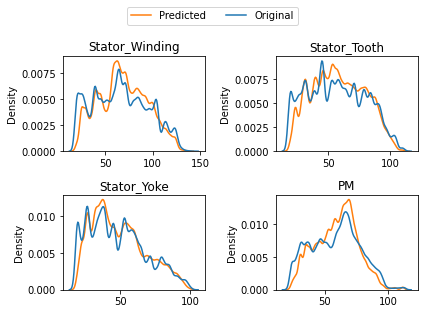

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `new_measures_df` synthetic data

Create the Random Forest Decision Tree Regressor and fit the data to it

In [ ]:
randForest = RandomForestRegressor(n_estimators = 10, random_state = 0)
randForest.fit(new_x_train_synth, new_y_train_synth)

RandomForestRegressor(n_estimators=10, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
new_rf_train_acc_synth = (randForest.score(new_x_train_synth, new_y_train_synth)) * 100
new_rf_test_acc_synth = (randForest.score(new_x_test_synth, new_y_test_synth)) * 100

print("Train Accuracy: ", new_rf_train_acc_synth)
print("Test Accuracy: ", new_rf_test_acc_synth)

Train Accuracy:  98.60548983701591
Test Accuracy:  74.00208839917862


Predict the test values

In [ ]:
tree_pred = randForest.predict(new_x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
new_rf_r2_synth = r2_score(new_y_test_synth, tree_pred)
new_rf_mae_synth = mean_absolute_error(new_y_test_synth, tree_pred)
new_rf_mse_synth = mean_squared_error(new_y_test_synth, tree_pred)

print("R2 Score: ", new_rf_r2_synth)
print("MAE: ", new_rf_mae_synth)
print("MSE: ", new_rf_mse_synth)

R2 Score:  0.7400208839917861
MAE:  7.107554934596905
MSE:  129.284588287014


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[new_y_test_synth, tree_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,53.430937,43.683791,33.830253,50.853938
1,85.115196,76.316637,67.217627,72.509083,73.552619,68.854711,64.669489,73.443598
2,48.690977,45.343004,39.481600,43.029770,64.598173,56.801189,47.795159,61.042761
3,104.791174,90.296399,72.123615,74.901335,72.730718,61.560360,52.030081,66.548465
4,113.346712,84.136667,57.476615,89.908331,113.125624,84.076787,57.479381,89.938312


Display a visualization of all the predictions compared with the original temperature

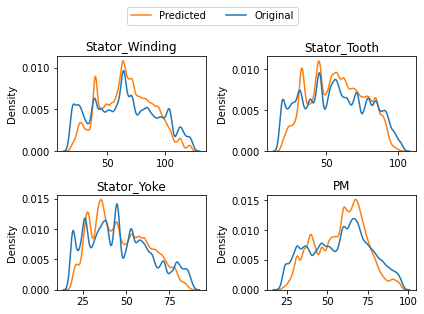

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `clean_measures_df` synthetic data

Create the Random Forest Decision Tree Regressor and fit the data to it

In [ ]:
randForest = RandomForestRegressor(n_estimators = 10, random_state = 0)
randForest.fit(clean_x_train_synth, clean_y_train_synth)

RandomForestRegressor(n_estimators=10, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
clean_rf_train_acc_synth = (randForest.score(clean_x_train_synth, clean_y_train_synth)) * 100
clean_rf_test_acc_synth = (randForest.score(clean_x_test_synth, clean_y_test_synth)) * 100

print("Train Accuracy: ", clean_rf_train_acc_synth)
print("Test Accuracy: ", clean_rf_test_acc_synth)

Train Accuracy:  98.75023296350638
Test Accuracy:  75.10984680865138


Predict the test values

In [ ]:
tree_pred = randForest.predict(clean_x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
clean_rf_r2_synth = r2_score(clean_y_test_synth, tree_pred)
clean_rf_mae_synth = mean_absolute_error(clean_y_test_synth, tree_pred)
clean_rf_mse_synth = mean_squared_error(clean_y_test_synth, tree_pred)

print("R2 Score: ", clean_rf_r2_synth)
print("MAE: ", clean_rf_mae_synth)
print("MSE: ", clean_rf_mse_synth)

R2 Score:  0.7510984680865138
MAE:  6.372810492069638
MSE:  93.37553196388346


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[clean_y_test_synth, tree_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,90.472439,79.636578,72.121382,62.382602,90.156270,80.601927,72.384927,64.532861
1,51.863004,44.360201,36.413628,57.271817,47.047390,40.093683,34.388094,47.398784
2,21.319025,19.852433,19.850618,29.767839,44.789638,38.304927,32.883723,45.959439
3,24.899328,23.305051,22.380061,28.442768,31.634876,27.943161,25.488182,29.707801
4,19.761168,19.161161,19.122271,27.059434,31.727038,28.219646,25.554094,38.887734


Display a visualization of all the predictions compared with the original temperature

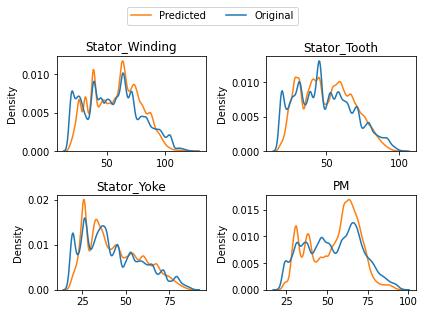

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

## K-Nearest Neighbour Model

### Model with `measures_df` data

Create the K-Nearest Neighbours Model called KNN. It is based off the Euclidean metric.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=10, p=2, metric='minkowski')
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=10)

Test the accuracy of the model for the training and testing sets

In [ ]:
knn_train_acc = (knn.score(x_train, y_train)) * 100
knn_test_acc = (knn.score(x_test, y_test)) * 100

print("Train Accuracy: ", knn_train_acc)
print("Test Accuracy: ", knn_test_acc)

Train Accuracy:  97.4811397751921
Test Accuracy:  72.42510091838821


Predict the test values

In [ ]:
knn_test_pred = knn.predict(x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
knn_r2 = r2_score(y_test, knn_test_pred)
knn_mae = mean_absolute_error(y_test, knn_test_pred)
knn_mse = mean_squared_error(y_test, knn_test_pred)

print("R2 Score: ", knn_r2)
print("MAE: ", knn_mae)
print("MSE: ", knn_mse)

R2 Score:  0.7242510091838821
MAE:  7.324021590702849
MSE:  154.5963029193525


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[y_test, knn_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,75.016397,53.919320,37.352737,44.864011
1,85.115196,76.316637,67.217627,72.509083,70.462468,65.588123,63.578684,72.132787
2,48.690977,45.343004,39.481600,43.029770,67.094144,57.937127,47.691530,64.388113
3,104.791174,90.296399,72.123615,74.901335,94.521600,78.445139,63.984736,75.213154
4,113.346712,84.136667,57.476615,89.908331,113.187344,84.320746,57.658175,90.720367


Display a visualization of all the predictions compared with the original temperature

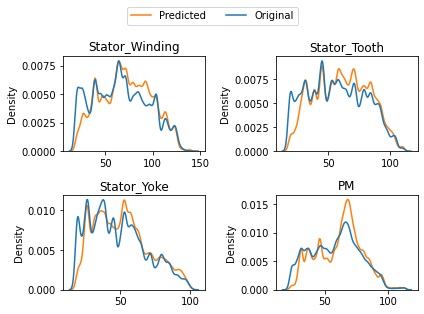

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `new_measures_df` data

Create the K-Nearest Neighbours Model called KNN. It is based off the Euclidean metric.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=10, p=2, metric='minkowski')
knn.fit(new_x_train, new_y_train)

KNeighborsRegressor(n_neighbors=10)

Test the accuracy of the model for the training and testing sets

In [ ]:
new_knn_train_acc = (knn.score(new_x_train, new_y_train)) * 100
new_knn_test_acc = (knn.score(new_x_test, new_y_test)) * 100

print("Train Accuracy: ", new_knn_train_acc)
print("Test Accuracy: ", new_knn_test_acc)

Train Accuracy:  95.96171927608451
Test Accuracy:  78.48949264150068


Predict the test values

In [ ]:
knn_test_pred = knn.predict(new_x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
new_knn_r2 = r2_score(new_y_test, knn_test_pred)
new_knn_mae = mean_absolute_error(new_y_test, knn_test_pred)
new_knn_mse = mean_squared_error(new_y_test, knn_test_pred)

print("R2 Score: ", new_knn_r2)
print("MAE: ", new_knn_mae)
print("MSE: ", new_knn_mse)

R2 Score:  0.7848949264150068
MAE:  4.99977018250111
MSE:  109.90532443009334


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[new_y_test, knn_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,71.794460,51.765845,35.666618,42.886558
1,85.115196,76.316637,67.217627,72.509083,84.131157,75.594692,67.032023,72.136862
2,48.690977,45.343004,39.481600,43.029770,50.168573,45.239034,39.193742,45.030330
3,104.791174,90.296399,72.123615,74.901335,97.540924,81.154878,64.784740,78.129223
4,113.346712,84.136667,57.476615,89.908331,113.010926,84.522382,57.672262,91.336081


Display a visualization of all the predictions compared with the original temperature

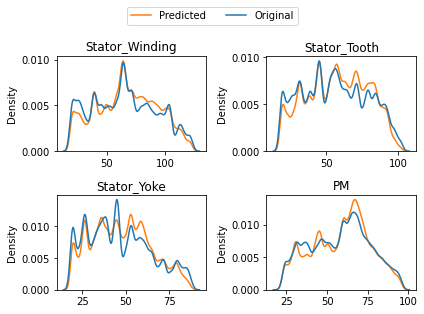

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `clean_measures_df` data

Create the K-Nearest Neighbours Model called KNN. It is based off the Euclidean metric.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=10, p=2, metric='minkowski')
knn.fit(clean_x_train, clean_y_train)

KNeighborsRegressor(n_neighbors=10)

Test the accuracy of the model for the training and testing sets

In [ ]:
clean_knn_train_acc = (knn.score(clean_x_train, clean_y_train)) * 100
clean_knn_test_acc = (knn.score(clean_x_test, clean_y_test)) * 100

print("Train Accuracy: ", clean_knn_train_acc)
print("Test Accuracy: ", clean_knn_test_acc)

Train Accuracy:  96.83504715410987
Test Accuracy:  92.75887438460438


Predict the test values

In [ ]:
knn_test_pred = knn.predict(clean_x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
clean_knn_r2 = r2_score(clean_y_test, knn_test_pred)
clean_knn_mae = mean_absolute_error(clean_y_test, knn_test_pred)
clean_knn_mse = mean_squared_error(clean_y_test, knn_test_pred)

print("R2 Score: ", clean_knn_r2)
print("MAE: ", clean_knn_mae)
print("MSE: ", clean_knn_mse)

R2 Score:  0.9275887438460438
MAE:  2.750448444059785
MSE:  27.92466043102039


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[clean_y_test, knn_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,90.472439,79.636578,72.121382,62.382602,90.337408,79.842151,71.266866,64.418239
1,51.863004,44.360201,36.413628,57.271817,51.609967,44.072647,36.223476,57.567560
2,21.319025,19.852433,19.850618,29.767839,21.796976,20.810342,19.850620,31.324040
3,24.899328,23.305051,22.380061,28.442768,19.401210,18.723803,18.799718,24.502085
4,19.761168,19.161161,19.122271,27.059434,23.854474,22.547463,21.642931,33.197469


Display a visualization of all the predictions compared with the original temperature

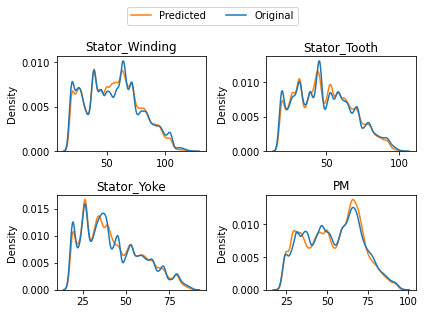

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `measures_df` synthetic data

Create the K-Nearest Neighbours Model called KNN. It is based off the Euclidean metric.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=10, p=2, metric='minkowski')
knn.fit(x_train_synth, y_train_synth)

KNeighborsRegressor(n_neighbors=10)

Test the accuracy of the model for the training and testing sets

In [ ]:
knn_train_acc_synth = (knn.score(x_train_synth, y_train_synth)) * 100
knn_test_acc_synth = (knn.score(x_test_synth, y_test_synth)) * 100

print("Train Accuracy: ", knn_train_acc_synth)
print("Test Accuracy: ", knn_test_acc_synth)

Train Accuracy:  94.41920413162083
Test Accuracy:  90.97788732134543


Predict the test values

In [ ]:
knn_test_pred = knn.predict(x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
knn_r2_synth = r2_score(y_test_synth, knn_test_pred)
knn_mae_synth = mean_absolute_error(y_test_synth, knn_test_pred)
knn_mse_synth = mean_squared_error(y_test_synth, knn_test_pred)

print("R2 Score: ", knn_r2_synth)
print("MAE: ", knn_mae_synth)
print("MSE: ", knn_mse_synth)

R2 Score:  0.9097788732134544
MAE:  4.074679103867311
MSE:  47.58568232240712


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[y_test_synth, knn_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,82.137572,59.388664,40.356712,49.912717
1,85.115196,76.316637,67.217627,72.509083,73.856028,68.740202,64.450714,71.467185
2,48.690977,45.343004,39.481600,43.029770,55.114638,49.554725,43.329098,52.787348
3,104.791174,90.296399,72.123615,74.901335,95.828680,78.944392,63.048815,78.228717
4,113.346712,84.136667,57.476615,89.908331,112.965400,83.805485,57.445035,87.128059


Display a visualization of all the predictions compared with the original temperature

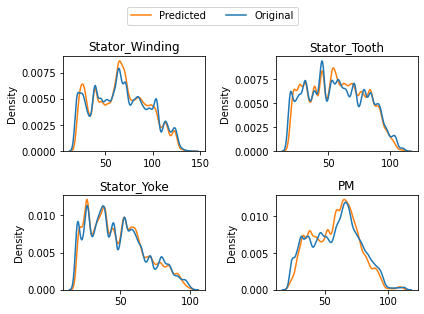

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `new_measures_df` synthetic data

Create the K-Nearest Neighbours Model called KNN. It is based off the Euclidean metric.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=10, p=2, metric='minkowski')
knn.fit(new_x_train_synth, new_y_train_synth)

KNeighborsRegressor(n_neighbors=10)

Test the accuracy of the model for the training and testing sets

In [ ]:
new_knn_train_acc_synth = (knn.score(new_x_train_synth, new_y_train_synth)) * 100
new_knn_test_acc_synth = (knn.score(new_x_test_synth, new_y_test_synth)) * 100

print("Train Accuracy: ", new_knn_train_acc_synth)
print("Test Accuracy: ", new_knn_test_acc_synth)

Train Accuracy:  92.53368761883442
Test Accuracy:  89.69556229661417


Predict the test values

In [ ]:
knn_test_pred = knn.predict(new_x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
new_knn_r2_synth = r2_score(new_y_test_synth, knn_test_pred)
new_knn_mae_synth = mean_absolute_error(new_y_test_synth, knn_test_pred)
new_knn_mse_synth = mean_squared_error(new_y_test_synth, knn_test_pred)

print("R2 Score: ", new_knn_r2_synth)
print("MAE: ", new_knn_mae_synth)
print("MSE: ", new_knn_mse_synth)

R2 Score:  0.8969556229661417
MAE:  3.7773122997606277
MSE:  48.67916964064558


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[new_y_test_synth, knn_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,64.841252,46.041121,32.356435,39.273950
1,85.115196,76.316637,67.217627,72.509083,79.172989,72.585436,66.189671,72.299149
2,48.690977,45.343004,39.481600,43.029770,56.617828,50.748366,44.267733,55.322483
3,104.791174,90.296399,72.123615,74.901335,84.427536,71.840994,59.241185,75.333745
4,113.346712,84.136667,57.476615,89.908331,113.120625,84.086984,57.487736,89.872302


Display a visualization of all the predictions compared with the original temperature

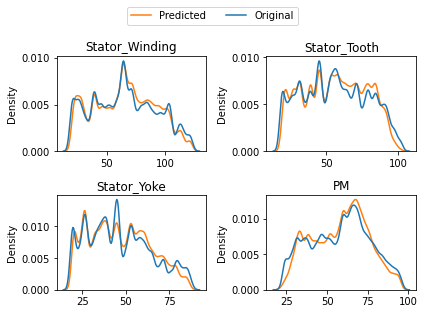

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `clean_measures_df` synthetic data

Create the K-Nearest Neighbours Model called KNN. It is based off the Euclidean metric.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=10, p=2, metric='minkowski')
knn.fit(clean_x_train_synth, clean_y_train_synth)

KNeighborsRegressor(n_neighbors=10)

Test the accuracy of the model for the training and testing sets

In [ ]:
clean_knn_train_acc_synth = (knn.score(clean_x_train_synth, clean_y_train_synth)) * 100
clean_knn_test_acc_synth = (knn.score(clean_x_test_synth, clean_y_test_synth)) * 100

print("Train Accuracy: ", clean_knn_train_acc_synth)
print("Test Accuracy: ", clean_knn_test_acc_synth)

Train Accuracy:  93.15123542895532
Test Accuracy:  87.3215962665223


Predict the test values

In [ ]:
knn_test_pred = knn.predict(clean_x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
clean_knn_r2_synth = r2_score(clean_y_test_synth, knn_test_pred)
clean_knn_mae_synth = mean_absolute_error(clean_y_test_synth, knn_test_pred)
clean_knn_mse_synth = mean_squared_error(clean_y_test_synth, knn_test_pred)

print("R2 Score: ", clean_knn_r2_synth)
print("MAE: ", clean_knn_mae_synth)
print("MSE: ", clean_knn_mse_synth)

R2 Score:  0.8732159626652231
MAE:  3.8799766032485947
MSE:  48.677273322858014


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[clean_y_test_synth, knn_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,90.472439,79.636578,72.121382,62.382602,102.613023,91.289744,80.612739,83.355540
1,51.863004,44.360201,36.413628,57.271817,57.899981,49.204857,40.313799,62.137097
2,21.319025,19.852433,19.850618,29.767839,21.405679,19.866351,19.850602,29.745516
3,24.899328,23.305051,22.380061,28.442768,21.748170,20.678585,20.334149,25.297788
4,19.761168,19.161161,19.122271,27.059434,19.775318,19.360063,19.114765,29.741631


Display a visualization of all the predictions compared with the original temperature

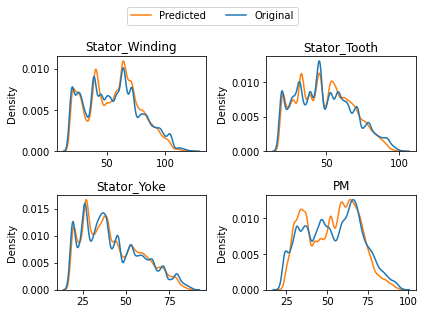

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

## Artificial Neural Network ANN (Mulit-Layer Perceptron Regressor)

### Model with `measures_df` data

First we create the model

In [ ]:
ann = MLPRegressor(max_iter=250, activation='tanh', random_state=0)

Now we fit our training data to it

In [ ]:
ann.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(activation='tanh', max_iter=250, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
ann_train_acc = (ann.score(x_train, y_train)) * 100
ann_test_acc = (ann.score(x_test, y_test)) * 100

print("Train Accuracy: ", ann_train_acc)
print("Test Accuracy: ", ann_test_acc)

Train Accuracy:  89.94773961833538
Test Accuracy:  84.14786570624753


Predict the test values

In [ ]:
ann_test_pred = ann.predict(x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
ann_r2 = r2_score(y_test, ann_test_pred)
ann_mae = mean_absolute_error(y_test, ann_test_pred)
ann_mse = mean_squared_error(y_test, ann_test_pred)

print("R2 Score: ", ann_r2)
print("MAE: ", ann_mae)
print("MSE: ", ann_mse)

R2 Score:  0.8414786570624753
MAE:  6.4102518546472655
MSE:  83.71258650403291


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[y_test, ann_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,66.340940,49.120259,35.455027,41.048625
1,85.115196,76.316637,67.217627,72.509083,68.240576,65.125423,63.121235,65.306772
2,48.690977,45.343004,39.481600,43.029770,45.688830,42.412865,39.811740,50.925185
3,104.791174,90.296399,72.123615,74.901335,90.207150,75.406094,61.458000,74.310752
4,113.346712,84.136667,57.476615,89.908331,113.955269,85.868701,59.525067,90.524539


Display a visualization of all the predictions compared with the original temperature

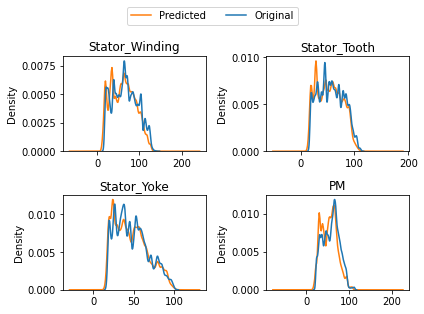

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `new_measures_df` data

First we create the model

In [ ]:
ann = MLPRegressor(max_iter=250, activation='tanh', random_state=0)

Now we fit our training data to it

In [ ]:
ann.fit(new_x_train, new_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(activation='tanh', max_iter=250, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
new_ann_train_acc = (ann.score(new_x_train, new_y_train)) * 100
new_ann_test_acc = (ann.score(new_x_test, new_y_test)) * 100

print("Train Accuracy: ", new_ann_train_acc)
print("Test Accuracy: ", new_ann_test_acc)

Train Accuracy:  84.02514700549534
Test Accuracy:  67.84137979982012


Predict the test values

In [ ]:
ann_test_pred = ann.predict(new_x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
new_ann_r2 = r2_score(new_y_test, ann_test_pred)
new_ann_mae = mean_absolute_error(new_y_test, ann_test_pred)
new_ann_mse = mean_squared_error(new_y_test, ann_test_pred)

print("R2 Score: ", new_ann_r2)
print("MAE: ", new_ann_mae)
print("MSE: ", new_ann_mse)

R2 Score:  0.6784137979982011
MAE:  8.266365185986855
MSE:  153.5033715478453


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[new_y_test, ann_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,68.303899,54.728719,42.377165,48.586181
1,85.115196,76.316637,67.217627,72.509083,65.563799,61.959851,60.376264,63.932881
2,48.690977,45.343004,39.481600,43.029770,48.169212,42.394360,37.330143,56.015094
3,104.791174,90.296399,72.123615,74.901335,87.847940,74.842499,62.894476,73.498670
4,113.346712,84.136667,57.476615,89.908331,110.370084,86.933081,60.296623,88.035420


Display a visualization of all the predictions compared with the original temperature

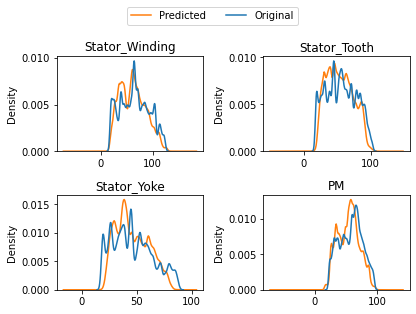

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `clean_measures_df` data

First we create the model

In [ ]:
ann = MLPRegressor(max_iter=250, activation='tanh', random_state=0)

Now we fit our training data to it

In [ ]:
ann.fit(clean_x_train, clean_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(activation='tanh', max_iter=250, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
clean_ann_train_acc = (ann.score(clean_x_train, clean_y_train)) * 100
clean_ann_test_acc = (ann.score(clean_x_test, clean_y_test)) * 100

print("Train Accuracy: ", clean_ann_train_acc)
print("Test Accuracy: ", clean_ann_test_acc)

Train Accuracy:  87.8184537161256
Test Accuracy:  87.7711440661555


Predict the test values

In [ ]:
ann_test_pred = ann.predict(clean_x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
clean_ann_r2 = r2_score(clean_y_test, ann_test_pred)
clean_ann_mae = mean_absolute_error(clean_y_test, ann_test_pred)
clean_ann_mse = mean_squared_error(clean_y_test, ann_test_pred)

print("R2 Score: ", clean_ann_r2)
print("MAE: ", clean_ann_mae)
print("MSE: ", clean_ann_mse)

R2 Score:  0.8777114406615549
MAE:  4.3083591105416374
MSE:  46.685699791824405


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[clean_y_test, ann_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,90.472439,79.636578,72.121382,62.382602,86.078584,78.706013,71.942285,67.460522
1,51.863004,44.360201,36.413628,57.271817,52.598857,43.773230,36.076325,51.173204
2,21.319025,19.852433,19.850618,29.767839,24.298941,22.831271,21.013937,33.804741
3,24.899328,23.305051,22.380061,28.442768,21.951790,20.784727,20.151888,27.522741
4,19.761168,19.161161,19.122271,27.059434,23.902342,22.298837,21.071132,31.313092


Display a visualization of all the predictions compared with the original temperature

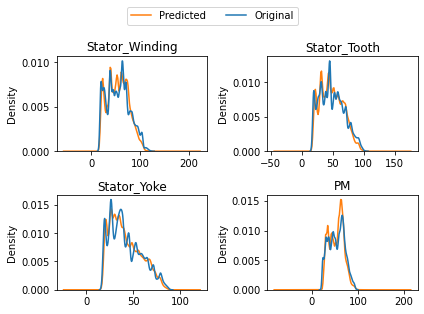

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `measures_df` synthetic data

First we create the model

In [ ]:
ann = MLPRegressor(max_iter=250, activation='tanh', random_state=0)

Now we fit our training data to it

In [ ]:
ann.fit(x_train_synth, y_train_synth)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(activation='tanh', max_iter=250, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
ann_train_acc_synth = (ann.score(x_train_synth, y_train_synth)) * 100
ann_test_acc_synth = (ann.score(x_test_synth, y_test_synth)) * 100

print("Train Accuracy: ", ann_train_acc_synth)
print("Test Accuracy: ", ann_test_acc_synth)

Train Accuracy:  81.14839712035568
Test Accuracy:  81.11986655078073


Predict the test values

In [ ]:
ann_test_pred = ann.predict(x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
ann_r2_synth = r2_score(y_test_synth, ann_test_pred)
ann_mae_synth = mean_absolute_error(y_test_synth, ann_test_pred)
ann_mse_synth = mean_squared_error(y_test_synth, ann_test_pred)

print("R2 Score: ", ann_r2_synth)
print("MAE: ", ann_mae_synth)
print("MSE: ", ann_mse_synth)

R2 Score:  0.8111986655078073
MAE:  6.775303592941736
MSE:  97.83781501636834


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[y_test_synth, ann_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,91.495971,68.335168,46.777576,72.294961
1,85.115196,76.316637,67.217627,72.509083,62.334138,60.056822,59.193189,60.553661
2,48.690977,45.343004,39.481600,43.029770,43.452071,40.680619,38.031040,55.708020
3,104.791174,90.296399,72.123615,74.901335,93.688797,77.276516,62.220670,76.882094
4,113.346712,84.136667,57.476615,89.908331,107.075097,79.467858,54.662309,81.879140


Display a visualization of all the predictions compared with the original temperature

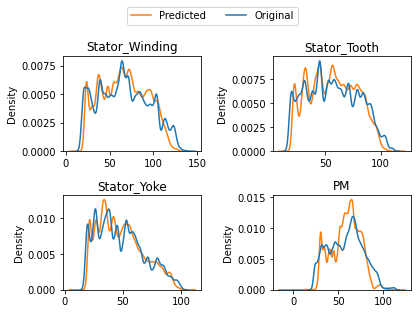

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `new_measures_df` synthetic data

First we create the model

In [ ]:
ann = MLPRegressor(max_iter=250, activation='tanh', random_state=0)

Now we fit our training data to it

In [ ]:
ann.fit(new_x_train_synth, new_y_train_synth)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(activation='tanh', max_iter=250, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
new_ann_train_acc_synth = (ann.score(new_x_train_synth, new_y_train_synth)) * 100
new_ann_test_acc_synth = (ann.score(new_x_test_synth, new_y_test_synth)) * 100

print("Train Accuracy: ", new_ann_train_acc_synth)
print("Test Accuracy: ", new_ann_test_acc_synth)

Train Accuracy:  76.02358823678887
Test Accuracy:  75.94891448923994


Predict the test values

In [ ]:
ann_test_pred = ann.predict(new_x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
new_ann_r2_synth = r2_score(new_y_test_synth, ann_test_pred)
new_ann_mae_synth = mean_absolute_error(new_y_test_synth, ann_test_pred)
new_ann_mse_synth = mean_squared_error(new_y_test_synth, ann_test_pred)

print("R2 Score: ", new_ann_r2_synth)
print("MAE: ", new_ann_mae_synth)
print("MSE: ", new_ann_mse_synth)

R2 Score:  0.7594891448923994
MAE:  7.314519570114775
MSE:  111.91751862447666


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[new_y_test_synth, ann_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.569468,46.061972,33.157576,40.009033,98.894474,75.536640,50.768122,70.964807
1,85.115196,76.316637,67.217627,72.509083,65.104954,61.679759,58.673523,61.902368
2,48.690977,45.343004,39.481600,43.029770,43.881276,41.006192,38.102526,56.246398
3,104.791174,90.296399,72.123615,74.901335,87.291108,72.098604,57.599063,67.074139
4,113.346712,84.136667,57.476615,89.908331,104.741426,79.063526,54.514098,81.022573


Display a visualization of all the predictions compared with the original temperature

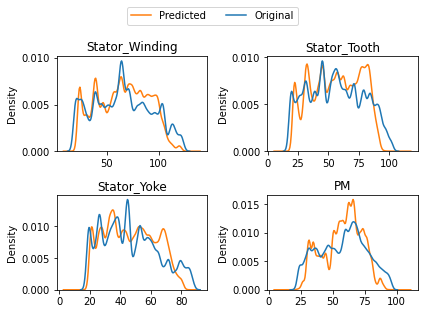

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

### Model with `clean_measures_df` synthetic data

First we create the model

In [ ]:
ann = MLPRegressor(max_iter=250, activation='tanh', random_state=0)

Now we fit our training data to it

In [ ]:
ann.fit(clean_x_train_synth, clean_y_train_synth)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(activation='tanh', max_iter=250, random_state=0)

Test the accuracy of the model for the training and testing sets

In [ ]:
clean_ann_train_acc_synth = (ann.score(clean_x_train_synth, clean_y_train_synth)) * 100
clean_ann_test_acc_synth = (ann.score(clean_x_test_synth, clean_y_test_synth)) * 100

print("Train Accuracy: ", clean_ann_train_acc_synth)
print("Test Accuracy: ", clean_ann_test_acc_synth)

Train Accuracy:  79.00051212532142
Test Accuracy:  78.57814694993127


Predict the test values

In [ ]:
ann_test_pred = ann.predict(clean_x_test_synth)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
clean_ann_r2_synth = r2_score(clean_y_test_synth, ann_test_pred)
clean_ann_mae_synth = mean_absolute_error(clean_y_test_synth, ann_test_pred)
clean_ann_mse_synth = mean_squared_error(clean_y_test_synth, ann_test_pred)

print("R2 Score: ", clean_ann_r2_synth)
print("MAE: ", clean_ann_mae_synth)
print("MSE: ", clean_ann_mse_synth)

R2 Score:  0.7857814694993126
MAE:  5.858748657805796
MSE:  79.26044826489714


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[clean_y_test_synth, ann_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,90.472439,79.636578,72.121382,62.382602,85.682947,78.448360,71.740993,69.927255
1,51.863004,44.360201,36.413628,57.271817,62.963375,51.489452,41.312140,57.091134
2,21.319025,19.852433,19.850618,29.767839,22.478596,21.609944,20.124574,33.107228
3,24.899328,23.305051,22.380061,28.442768,22.264525,21.028251,20.260172,28.837503
4,19.761168,19.161161,19.122271,27.059434,21.906159,20.648085,19.817777,28.918564


Display a visualization of all the predictions compared with the original temperature

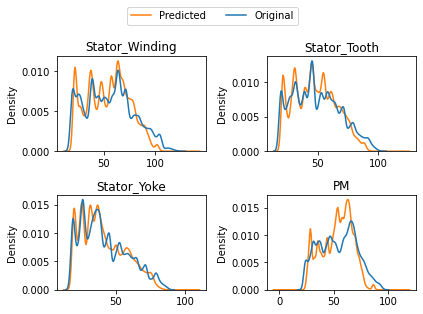

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()

# Model Comparison

## Models trained and tested on `measures_df`

Create a table of models

In [ ]:
models = pd.DataFrame({
    'Model': ['Lin', 'RF', 'KNN', 'ANN'],
    'Training Accuracy' : [train_acc, rf_train_acc, knn_train_acc, ann_train_acc],
    'Testing Accuracy' : [test_acc, rf_test_acc, knn_test_acc, ann_test_acc],
    'MSE Score' : [lin_mse, rf_mse, knn_mse, ann_mse],
    'MAE Score' : [lin_mae, rf_mae, knn_mae, ann_mae],
    'R2 Score': [lin_r2, rf_r2, knn_r2, ann_r2]
})

models.sort_values(by = ['Training Accuracy', 'Testing Accuracy', 'MSE Score', 'MAE Score', 'R2 Score'], ascending = True)

,Model,Training Accuracy,Testing Accuracy,MSE Score,MAE Score,R2 Score
0,Lin,73.382545,71.833462,148.879198,9.258639,0.718335
3,ANN,90.046058,88.004805,64.592425,5.404838,0.880048
2,KNN,97.388265,71.222416,163.667932,7.347286,0.712224
1,RF,99.813091,67.278468,183.134037,9.131448,0.672785


Display bar graphs comparing the models performance

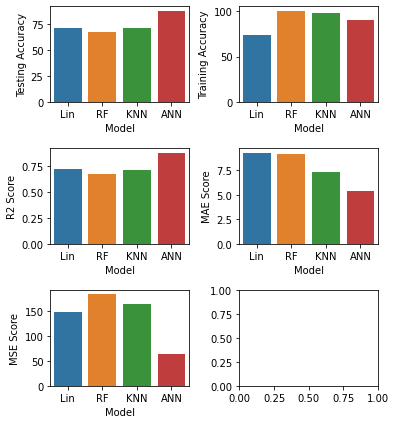

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(5.6, 6))
sns.barplot(ax=axs[0, 0], x='Model', y='Testing Accuracy', data=models)
sns.barplot(ax=axs[0, 1], x='Model', y='Training Accuracy', data=models)
sns.barplot(ax=axs[1, 0], x='Model', y='R2 Score', data=models)
sns.barplot(ax=axs[1, 1], x='Model', y='MAE Score', data=models)
sns.barplot(ax=axs[2, 0], x='Model', y='MSE Score', data=models)

plt.tight_layout()

plt.show()

## Models trained and tested on `new_measures_df`

Create a table of models

In [ ]:
models = pd.DataFrame({
    'Model': ['Lin', 'RF', 'KNN', 'ANN'],
    'Training Accuracy' : [new_train_acc, new_rf_train_acc, new_knn_train_acc, new_ann_train_acc],
    'Testing Accuracy' : [new_test_acc, new_rf_test_acc, new_knn_test_acc, new_ann_test_acc],
    'MSE Score' : [new_lin_mse, new_rf_mse, new_knn_mse, new_ann_mse],
    'MAE Score' : [new_lin_mae, new_rf_mae, new_knn_mae, new_ann_mae],
    'R2 Score': [new_lin_r2, new_rf_r2, new_knn_r2, new_ann_r2]
})

models.sort_values(by = ['Training Accuracy', 'Testing Accuracy', 'MSE Score', 'MAE Score', 'R2 Score'], ascending = True)

,Model,Training Accuracy,Testing Accuracy,MSE Score,MAE Score,R2 Score
0,Lin,51.421306,51.392597,235.284726,11.525350,0.513926
3,ANN,84.341261,76.315457,113.532176,7.065371,0.763155
2,KNN,95.981404,81.163851,96.654728,4.543369,0.811639
1,RF,99.681334,63.939701,179.678096,8.138418,0.639397


Display bar graphs comparing the models performance

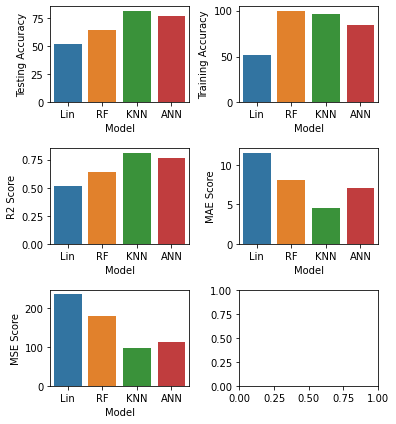

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(5.6, 6))
sns.barplot(ax=axs[0, 0], x='Model', y='Testing Accuracy', data=models)
sns.barplot(ax=axs[0, 1], x='Model', y='Training Accuracy', data=models)
sns.barplot(ax=axs[1, 0], x='Model', y='R2 Score', data=models)
sns.barplot(ax=axs[1, 1], x='Model', y='MAE Score', data=models)
sns.barplot(ax=axs[2, 0], x='Model', y='MSE Score', data=models)

plt.tight_layout()

plt.show()

## Models trained and tested on `clean_measures_df`

Create a table of models

In [ ]:
models = pd.DataFrame({
    'Model': ['Lin', 'RF', 'KNN', 'ANN'],
    'Training Accuracy' : [clean_train_acc, clean_rf_train_acc, clean_knn_train_acc, clean_ann_train_acc],
    'Testing Accuracy' : [clean_test_acc, clean_rf_test_acc, clean_knn_test_acc, clean_ann_test_acc],
    'MSE Score' : [clean_lin_mse, clean_rf_mse, clean_knn_mse, clean_ann_mse],
    'MAE Score' : [clean_lin_mae, clean_rf_mae, clean_knn_mae, clean_ann_mae],
    'R2 Score': [clean_lin_r2, clean_rf_r2, clean_knn_r2, clean_ann_r2]
})

models.sort_values(by = ['Training Accuracy', 'Testing Accuracy', 'MSE Score', 'MAE Score', 'R2 Score'], ascending = True)

,Model,Training Accuracy,Testing Accuracy,MSE Score,MAE Score,R2 Score
0,Lin,44.052803,44.034565,202.688902,11.134611,0.440346
3,ANN,79.066215,78.107563,81.011201,5.971157,0.781076
2,KNN,92.829497,82.870697,65.404911,4.824470,0.828707
1,RF,98.701952,75.659239,92.221495,6.512106,0.756592


Display bar graphs comparing the models performance

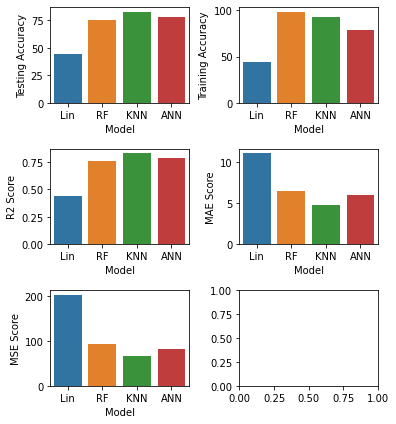

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(5.6, 6))
sns.barplot(ax=axs[0, 0], x='Model', y='Testing Accuracy', data=models)
sns.barplot(ax=axs[0, 1], x='Model', y='Training Accuracy', data=models)
sns.barplot(ax=axs[1, 0], x='Model', y='R2 Score', data=models)
sns.barplot(ax=axs[1, 1], x='Model', y='MAE Score', data=models)
sns.barplot(ax=axs[2, 0], x='Model', y='MSE Score', data=models)

plt.tight_layout()

plt.show()